<a href="https://colab.research.google.com/github/spatank/CIS-522-Project/blob/main/shubhankar_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/Shareddrives/CIS-522-Project/')

Mounted at /content/drive


In [2]:
!ls

 Abstract.gdoc			  Presentation.gslides
 anna_code.ipynb		  shubhankar_code
'CIS 522 Project Proposal.gdoc'   train
 group_code.ipynb		  train_keep.csv
 jake_code.ipynb		  Writeup.gdoc
 plant-pathology-2021-fgvc8.zip


In [3]:
# Imports

import os
import cv2
from tqdm.auto import tqdm

import time
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import preprocessing
from PIL import Image

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

(device(type='cuda'), 1)

In [4]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label = 'Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label = 'Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label = 'Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label = 'Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [5]:
df = pd.read_csv("/content/drive/Shareddrives/CIS-522-Project/train_keep.csv")
le = preprocessing.LabelEncoder()
le.fit(df['labels'])
df['label'] = le.transform(df['labels'])
df.head(5)

,image,labels,label
0,800113bb65efe69e.jpg,healthy,0
1,80070f7fb5e2ccaa.jpg,scab,1
2,80077517781fb94f.jpg,scab,1
3,800edef467d27c15.jpg,healthy,0
4,801d6dcd96e48ebc.jpg,healthy,0


In [6]:
# df['label'] = df['label'] * -2 + 1 # Convert to 1 = healthy, -1 = scab
# df.head(5)

In [7]:
X, y = df['image'].values, df['label'].values

In [8]:
transform = transforms.Compose([
     transforms.Resize((128, 128)),                                 
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
     ])

class GetData(Dataset):
    def __init__(self, Dir, FNames, Labels, Transform):
        self.dir = Dir
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(os.path.join(self.dir, self.fnames[index]))
    
        return self.transform(x), self.labels[index]

img_dataset = GetData('/content/drive/Shareddrives/CIS-522-Project/train/train_keep', X, y, transform)

In [9]:
train_size = int(0.7 * len(img_dataset))
val_size = len(img_dataset) - train_size
img_train_data, img_val_data = torch.utils.data.random_split(img_dataset, [train_size, val_size])

batch_size = 128
train_loader = torch.utils.data.DataLoader(img_train_data, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(img_val_data, batch_size = batch_size)

In [10]:
class base_net(nn.Module):
    def __init__(self):
        super(base_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(246016, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
       
        return x

def train(model, device, train_loader, validation_loader, epochs):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                              lr = 0.01, momentum = 0.9)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        # keeps track of the running loss
        running_loss = 0.

        correct, total = 0, 0 
        with tqdm(train_loader, unit = 'batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:

                data, target = data.to(device), target.to(device)

                # COMPLETE CODE FOR TRAINING LOOOP
                # 1. Get the model output
                output = model(data)
                # print(target.shape, output.shape)
                # 2. Zero the gradients out
                optimizer.zero_grad()
                # 3. Get the Loss
                loss = criterion(output, target)
                # 4. Calculate the gradients
                loss.backward()
                # 5. Update the weights
                optimizer.step()
  
                # set loss to whatever you end up naming your variable when 
                # calling criterion
                # for example, loss = criterion(output, target)
                # then set loss = loss.item() in the set_postfix function
                tepoch.set_postfix(loss = loss.item())
                running_loss += loss.item()
                
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        train_loss.append(running_loss/len(train_loader))  # append the loss for this epoch
        train_acc.append(correct/total)
                
        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit = 'batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
    
    return train_loss, train_acc, validation_loss, validation_acc

In [11]:
net = base_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 20)

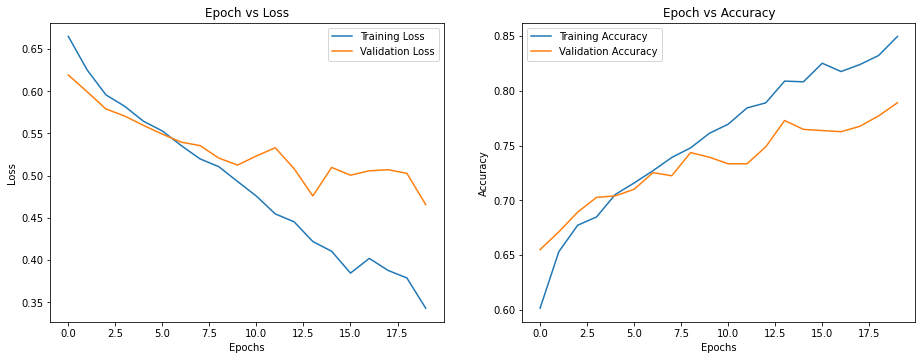

In [12]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)